In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

import Models
from HigherTier import HigherTierModel
from HigherTier import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*_track.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_1_track.npz', '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_track.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 6
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 19))
variables_test = np.empty((0, 19))
# Training cut
trainingCutDCA_train = np.empty((0), dtype='float')
trainingCutDCA_test = np.empty((0), dtype='float')
# Truth
y_train = np.empty((0, 2))
y_test = np.empty((0, 2))
isTruePrimaryLink_train = np.empty((0), dtype='int')
isTruePrimaryLink_test = np.empty((0), dtype='int')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Training cut
    trainingCutDCA_train = np.concatenate((trainingCutDCA_train, data['trainingCutDCA_train']), axis=0)
    trainingCutDCA_test = np.concatenate((trainingCutDCA_test, data['trainingCutDCA_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    isTruePrimaryLink_train = np.concatenate((isTruePrimaryLink_train, data['isTruePrimaryLink_train']), axis=0)
    isTruePrimaryLink_test = np.concatenate((isTruePrimaryLink_test, data['isTruePrimaryLink_test']), axis=0)                                             

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_1_track.npz , This may take a while...
Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_track.npz , This may take a while...


In [5]:
###########################################################
# I made a mistake with the opening angle so delete it for now :(
###########################################################

variables_train = np.delete(variables_train, [9,18], axis=1)
variables_test = np.delete(variables_test, [9,18], axis=1)

In [6]:
# import math

# minValue = np.min(variables_train[:, 9][variables_train[:, 9] > -1])

# for i in range(variables_train.shape[0]) : 
#     if (math.isnan(variables_train[i][9]) or math.isinf(variables_train[i][9])) :
#         variables_train[i][9] = minValue
        
#     if (math.isnan(variables_train[i][18]) or math.isinf(variables_train[i][18])) :
#         variables_train[i][18] = minValue        
        
# for i in range(variables_test.shape[0]) : 
#     if (math.isnan(variables_test[i][9]) or math.isinf(variables_test[i][9])) :
#         variables_test[i][9] = minValue
        
#     if (math.isnan(variables_test[i][18]) or math.isinf(variables_test[i][18])) :
#         variables_test[i][18] = minValue        

In [7]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('')
print('ntrain:', ntrain)
print('ntest:', ntest)

variables_train.shape: (672935, 17)
variables_test.shape: (74772, 17)
y_train.shape: (672935, 2)
y_test.shape: (74772, 2)
trainingCutDCA_train.shape: (672935,)
trainingCutDCA_test.shape: (74772,)
isTruePrimaryLink_train.shape: (672935,)
isTruePrimaryLink_test.shape: (74772,)

ntrain: 672935
ntest: 74772


In [8]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_DCA = 50.0

######################
# training set first
######################
# Make mask
passTrainingCutDCA_train = trainingCutDCA_train < MAX_TRAINING_CUT_DCA
passTrainingCuts_train = passTrainingCutDCA_train

# Mask the 1D variables... shape=(nEntries, )
trainingCutDCA_train = trainingCutDCA_train[passTrainingCuts_train]
isTruePrimaryLink_train = isTruePrimaryLink_train[passTrainingCuts_train]

# Mask the truth... shape=(nEntries, nLinks)
y_train = y_train[np.column_stack((passTrainingCuts_train, passTrainingCuts_train))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutDCA_test = trainingCutDCA_test < MAX_TRAINING_CUT_DCA
passTrainingCuts_test = passTrainingCutDCA_test

# Mask the 1D variables... shape=(nEntries, )
trainingCutDCA_test = trainingCutDCA_test[passTrainingCuts_test]
isTruePrimaryLink_test = isTruePrimaryLink_test[passTrainingCuts_test]

# Mask the truth... shape=(nEntries, nLinks)
y_test = y_test[np.column_stack((passTrainingCuts_test, passTrainingCuts_test))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

In [9]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('')
print('ntrain:', ntrain)
print('ntest:', ntest)

variables_train.shape: (532463, 17)
variables_test.shape: (59235, 17)
y_train.shape: (532463, 2)
y_test.shape: (59235, 2)
trainingCutDCA_train.shape: (532463,)
trainingCutDCA_test.shape: (59235,)
isTruePrimaryLink_train.shape: (532463,)
isTruePrimaryLink_test.shape: (59235,)

ntrain: 532463
ntest: 59235


In [10]:
###########################################################
# Work out weights
###########################################################

n_true_primary_train = np.count_nonzero(isTruePrimaryLink_train == True)
n_false_primary_train = np.count_nonzero(isTruePrimaryLink_train == False)

print('n_true_primary_train:', n_true_primary_train)
print('n_false_primary_train:', n_false_primary_train)

maxCounts_train = max(n_true_primary_train, n_false_primary_train)

classWeights_train = {'true_primary_train'  : maxCounts_train/n_true_primary_train, \
                      'false_primary_train' : maxCounts_train/n_false_primary_train, \
                     }

print('classWeights_train:', classWeights_train)

classWeights_train['true_primary_train'] = round(classWeights_train['true_primary_train'])
classWeights_train['false_primary_train'] = round(classWeights_train['false_primary_train'])

print('classWeights_train:', classWeights_train)


n_true_primary_train: 461832
n_false_primary_train: 70631
classWeights_train: {'true_primary_train': 1.0, 'false_primary_train': 6.538658662626892}
classWeights_train: {'true_primary_train': 1, 'false_primary_train': 7}


In [11]:
###########################################################
# Is test similar?
###########################################################

n_true_primary_test = np.count_nonzero(isTruePrimaryLink_test == True)
n_false_primary_test = np.count_nonzero(isTruePrimaryLink_test == False)

print('n_true_primary_test:', n_true_primary_test)
print('n_false_primary_test:', n_false_primary_test)

maxCounts_test = max(n_true_primary_test, n_false_primary_test)

classWeights_test = {'true_primary_test'  : maxCounts_test/n_true_primary_test, \
                      'false_primary_test' : maxCounts_test/n_false_primary_test, \
                     }

print('classWeights_test:', classWeights_test)

classWeights_test['true_primary_test'] = round(classWeights_test['true_primary_test'])
classWeights_test['false_primary_test'] = round(classWeights_test['false_primary_test'])

print('classWeights_test:', classWeights_test)


n_true_primary_test: 51517
n_false_primary_test: 7718
classWeights_test: {'true_primary_test': 1.0, 'false_primary_test': 6.67491578129049}
classWeights_test: {'true_primary_test': 1, 'false_primary_test': 7}


In [12]:
###########################################################
# Split it into two again
###########################################################

n_links = 2
n_global_vars = 1
n_link_vars = 8

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train_temp = variables_train
input_1_train_temp = np.concatenate((input_0_train_temp[:,0:i_end_of_global_vars], input_0_train_temp[:,i_target_start:], input_0_train_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_train_temp = y_train[:,0]
y_1_train_temp = y_train[:,1]

isTruePrimaryLink_train_temp = isTruePrimaryLink_train

# Test
input_0_test_temp = variables_test
input_1_test_temp = np.concatenate((input_0_test_temp[:,0:i_end_of_global_vars], input_0_test_temp[:,i_target_start:], input_0_test_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_test_temp = y_test[:,0]
y_1_test_temp = y_test[:,1]

isTruePrimaryLink_test_temp = isTruePrimaryLink_test

In [13]:
###########################################################
# Mimic the weighting of the loss function random.NextDouble() < probability; 
###########################################################

weight_train = np.zeros(isTruePrimaryLink_train_temp.shape, dtype='int')
weight_train[isTruePrimaryLink_train_temp == True] = classWeights_train['true_primary_train']
weight_train[isTruePrimaryLink_train_temp == False] = classWeights_train['false_primary_train']

weight_test = np.zeros(isTruePrimaryLink_test_temp.shape, dtype='int')
weight_test[isTruePrimaryLink_test_temp == True] = classWeights_train['true_primary_train']
weight_test[isTruePrimaryLink_test_temp == False] = classWeights_train['false_primary_train']

input_0_train = [input_0_train_temp[i] for i in range(isTruePrimaryLink_train_temp.shape[0]) for _ in range(weight_train[i])]
input_1_train = [input_1_train_temp[i] for i in range(isTruePrimaryLink_train_temp.shape[0]) for _ in range(weight_train[i])]
y_0_train = [y_0_train_temp[i] for i in range(isTruePrimaryLink_train_temp.shape[0]) for _ in range(weight_train[i])]
y_1_train = [y_1_train_temp[i] for i in range(isTruePrimaryLink_train_temp.shape[0]) for _ in range(weight_train[i])]
isTruePrimaryLink_train = [isTruePrimaryLink_train_temp[i] for i in range(isTruePrimaryLink_train_temp.shape[0]) for _ in range(weight_train[i])]

input_0_test = [input_0_test_temp[i] for i in range(isTruePrimaryLink_test_temp.shape[0]) for _ in range(weight_test[i])]
input_1_test = [input_1_test_temp[i] for i in range(isTruePrimaryLink_test_temp.shape[0]) for _ in range(weight_test[i])]
y_0_test = [y_0_test_temp[i] for i in range(isTruePrimaryLink_test_temp.shape[0]) for _ in range(weight_test[i])]
y_1_test = [y_1_test_temp[i] for i in range(isTruePrimaryLink_test_temp.shape[0]) for _ in range(weight_test[i])]
isTruePrimaryLink_test = [isTruePrimaryLink_test_temp[i] for i in range(isTruePrimaryLink_test_temp.shape[0]) for _ in range(weight_test[i])]

input_0_train = np.array(input_0_train)
input_1_train = np.array(input_1_train)
y_0_train = to_categorical(np.array(y_0_train), 3)
y_1_train = to_categorical(np.array(y_1_train), 3)
isTruePrimaryLink_train = np.array(isTruePrimaryLink_train)
    
input_0_test = np.array(input_0_test)
input_1_test = np.array(input_1_test)
y_0_test = to_categorical(np.array(y_0_test), 3)
y_1_test = to_categorical(np.array(y_1_test), 3)
isTruePrimaryLink_test = np.array(isTruePrimaryLink_test)

In [14]:
###########################################################
# Check shapes
###########################################################

print('input_0_train:', input_0_train.shape)
print('input_1_train:', input_1_train.shape)

print('y_0_train:', y_0_train.shape)
print('y_1_train:', y_1_train.shape)

print('input_0_test:', input_0_test.shape)
print('input_1_test:', input_1_test.shape)

print('y_0_test:', y_0_test.shape)
print('y_1_test:', y_1_test.shape)

input_0_train: (956249, 17)
input_1_train: (956249, 17)
y_0_train: (956249, 3)
y_1_train: (956249, 3)
input_0_test: (105543, 17)
input_1_test: (105543, 17)
y_0_test: (105543, 3)
y_1_test: (105543, 3)


In [15]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_final = Models.PrimaryTierGroupModel_tracks(nVariables, dropoutRate=0.5)
optimiser_final = optimizers.legacy.Adam(learning_rate=learningRate)
model_final.compile(optimizer=optimiser_final, metrics=['accuracy'], loss=['categorical_crossentropy', 'categorical_crossentropy', 'binary_crossentropy'])

In [16]:
# ###########################################################
# # Define class weights
# ###########################################################

# nTrue_final = np.count_nonzero(isTruePrimaryLink_train == 1)
# nBackground_final = np.count_nonzero(isTruePrimaryLink_train == 0)

# maxLinks = max(nTrue_final, nBackground_final)

# classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

# print('nTrue_final:', nTrue_final)
# print('nBackground_final:', nBackground_final)
# print('classWeights_final:', classWeights_final)

In [17]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_final_prediction_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model_final.fit([input_0_train, input_1_train], [y_0_train, y_1_train, isTruePrimaryLink_train], \
                                validation_data=([input_0_test, input_1_test], [y_0_test, y_1_test, isTruePrimaryLink_test]), \
                                batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final)

Epoch 1/6
14929/14942 [============================>.] - ETA: 0s - loss: 1.2425 - orientation_0_loss: 0.4348 - orientation_1_loss: 0.4360 - final_prediction_loss: 0.3717 - orientation_0_accuracy: 0.8345 - orientation_1_accuracy: 0.8341 - final_prediction_accuracy: 0.8471
Epoch 1: val_final_prediction_accuracy improved from -inf to 0.85726, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel/assets


14942/14942 [==============================] - 23s 2ms/step - loss: 1.2424 - orientation_0_loss: 0.4348 - orientation_1_loss: 0.4359 - final_prediction_loss: 0.3716 - orientation_0_accuracy: 0.8345 - orientation_1_accuracy: 0.8341 - final_prediction_accuracy: 0.8471 - val_loss: 1.1226 - val_orientation_0_loss: 0.3862 - val_orientation_1_loss: 0.3864 - val_final_prediction_loss: 0.3500 - val_orientation_0_accuracy: 0.8479 - val_orientation_1_accuracy: 0.8463 - val_final_prediction_accuracy: 0.8573 - lr: 0.0010
Epoch 2/6
14932/14942 [============================>.] - ETA: 0s - loss: 1.1433 - orientation_0_loss: 0.3999 - orientation_1_loss: 0.4015 - final_prediction_loss: 0.3419 - orientation_0_accuracy: 0.8438 - orientation_1_accuracy: 0.8434 - final_prediction_accuracy: 0.8557
Epoch 2: val_final_prediction_accuracy did not improve from 0.85726
14942/14942 [==============================] - 23s 2ms/step - loss: 1.1433 - orientation_0_loss: 0.3999 - orientation_1_loss: 0.4015 - final_pred

INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel/assets



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
14942/14942 [==============================] - 26s 2ms/step - loss: 1.1217 - orientation_0_loss: 0.3927 - orientation_1_loss: 0.3938 - final_prediction_loss: 0.3352 - orientation_0_accuracy: 0.8451 - orientation_1_accuracy: 0.8446 - final_prediction_accuracy: 0.8570 - val_loss: 1.1612 - val_orientation_0_loss: 0.3883 - val_orientation_1_loss: 0.3858 - val_final_prediction_loss: 0.3871 - val_orientation_0_accuracy: 0.8485 - val_orientation_1_accuracy: 0.8490 - val_final_prediction_accuracy: 0.8596 - lr: 0.0010
Epoch 4/6
14939/14942 [============================>.] - ETA: 0s - loss: 1.0890 - orientation_0_loss: 0.3811 - orientation_1_loss: 0.3821 - final_prediction_loss: 0.3259 - orientation_0_accuracy: 0.8478 - orientation_1_accuracy: 0.8476 - final_prediction_accuracy: 0.8590
Epoch 4: val_final_prediction_accuracy improved from 0.85956 to 0.86019, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/mode

INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel/assets


14942/14942 [==============================] - 26s 2ms/step - loss: 1.0890 - orientation_0_loss: 0.3811 - orientation_1_loss: 0.3821 - final_prediction_loss: 0.3259 - orientation_0_accuracy: 0.8478 - orientation_1_accuracy: 0.8476 - final_prediction_accuracy: 0.8590 - val_loss: 1.1178 - val_orientation_0_loss: 0.3726 - val_orientation_1_loss: 0.3746 - val_final_prediction_loss: 0.3705 - val_orientation_0_accuracy: 0.8508 - val_orientation_1_accuracy: 0.8489 - val_final_prediction_accuracy: 0.8602 - lr: 1.0000e-04
Epoch 5/6
14921/14942 [============================>.] - ETA: 0s - loss: 1.0810 - orientation_0_loss: 0.3777 - orientation_1_loss: 0.3795 - final_prediction_loss: 0.3238 - orientation_0_accuracy: 0.8487 - orientation_1_accuracy: 0.8480 - final_prediction_accuracy: 0.8594
Epoch 5: val_final_prediction_accuracy improved from 0.86019 to 0.86127, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel
INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel/assets


14942/14942 [==============================] - 26s 2ms/step - loss: 1.0810 - orientation_0_loss: 0.3777 - orientation_1_loss: 0.3795 - final_prediction_loss: 0.3238 - orientation_0_accuracy: 0.8487 - orientation_1_accuracy: 0.8480 - final_prediction_accuracy: 0.8594 - val_loss: 1.1119 - val_orientation_0_loss: 0.3725 - val_orientation_1_loss: 0.3728 - val_final_prediction_loss: 0.3667 - val_orientation_0_accuracy: 0.8506 - val_orientation_1_accuracy: 0.8500 - val_final_prediction_accuracy: 0.8613 - lr: 1.0000e-04
Epoch 6/6
14937/14942 [============================>.] - ETA: 0s - loss: 1.0769 - orientation_0_loss: 0.3767 - orientation_1_loss: 0.3775 - final_prediction_loss: 0.3226 - orientation_0_accuracy: 0.8484 - orientation_1_accuracy: 0.8483 - final_prediction_accuracy: 0.8597
Epoch 6: val_final_prediction_accuracy improved from 0.86127 to 0.86128, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel
INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_track_oneModel/assets


14942/14942 [==============================] - 33s 2ms/step - loss: 1.0769 - orientation_0_loss: 0.3768 - orientation_1_loss: 0.3775 - final_prediction_loss: 0.3226 - orientation_0_accuracy: 0.8484 - orientation_1_accuracy: 0.8483 - final_prediction_accuracy: 0.8597 - val_loss: 1.1094 - val_orientation_0_loss: 0.3698 - val_orientation_1_loss: 0.3719 - val_final_prediction_loss: 0.3677 - val_orientation_0_accuracy: 0.8516 - val_orientation_1_accuracy: 0.8509 - val_final_prediction_accuracy: 0.8613 - lr: 1.0000e-04


dict_keys(['loss', 'orientation_0_loss', 'orientation_1_loss', 'final_prediction_loss', 'orientation_0_accuracy', 'orientation_1_accuracy', 'final_prediction_accuracy', 'val_loss', 'val_orientation_0_loss', 'val_orientation_1_loss', 'val_final_prediction_loss', 'val_orientation_0_accuracy', 'val_orientation_1_accuracy', 'val_final_prediction_accuracy', 'lr'])


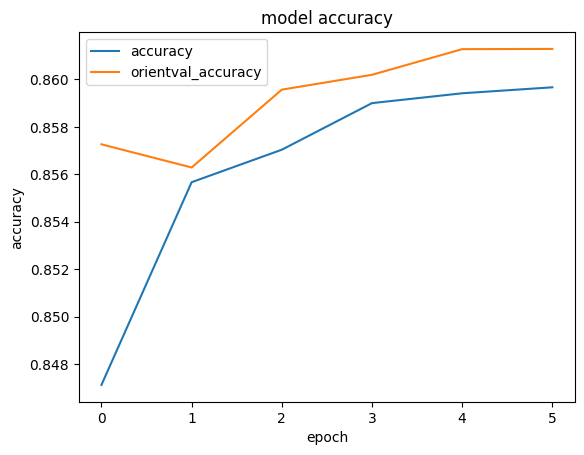

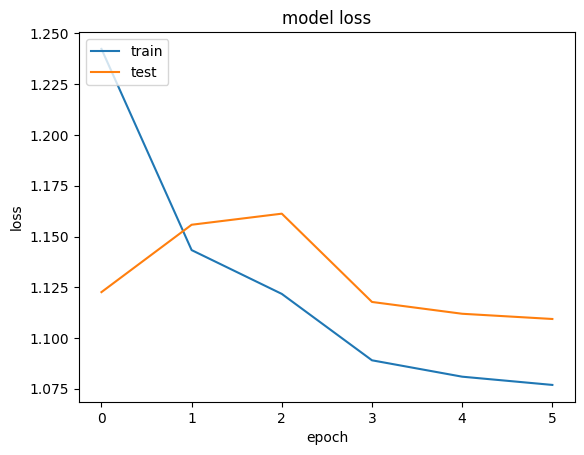

In [18]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['final_prediction_accuracy'])
plt.plot(history_final.history['val_final_prediction_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model_final.predict([input_0_train, input_1_train])
y_pred_final_test = model_final.predict([input_0_test, input_1_test])

3299/3299 [==============================] - 1s 438us/step


In [20]:
y_pred_final_test = np.array(y_pred_final_test[2])

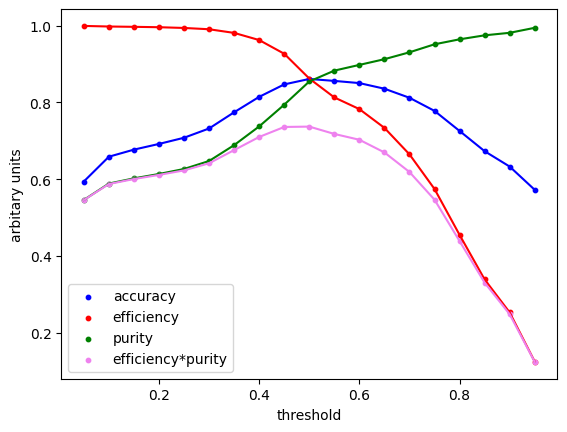

optimal_threshold_metric: 0.5


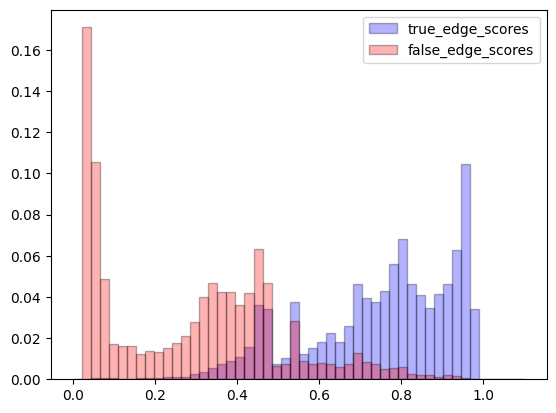

[[46473  7553]
 [ 7088 44429]]
[[46473  7553]
 [ 7088 44429]]


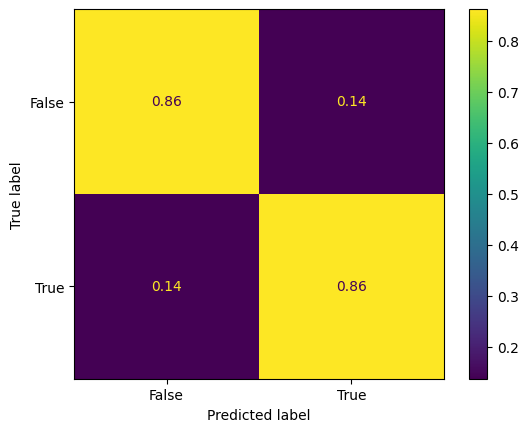

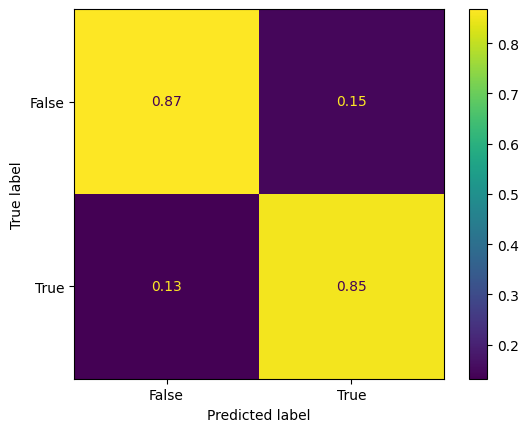

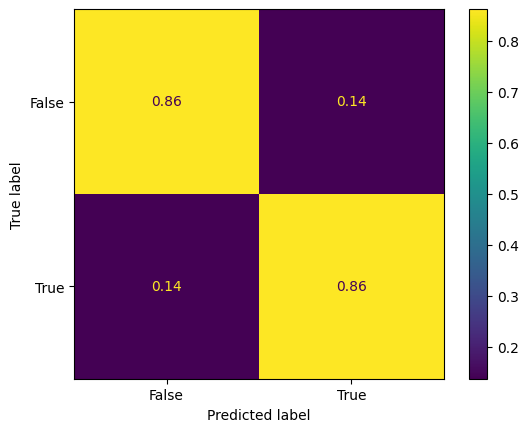

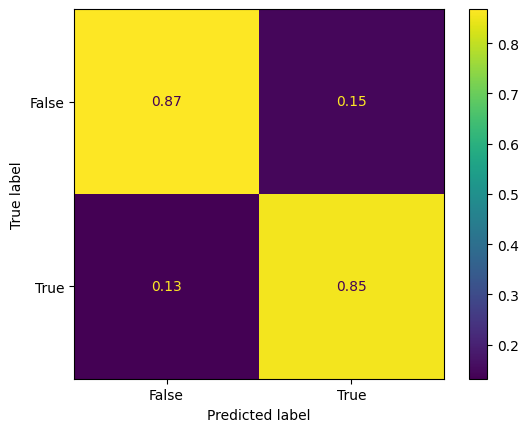

In [21]:
#######################################
# Plot final link prediction 
#######################################
optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, isTruePrimaryLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, isTruePrimaryLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, optimal_threshold_metric)
